In [ ]:
#!g1.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
#!g1.1
import os
recovery_names = os.listdir("data/recovery_sliced")
interval_names = os.listdir("data/interval_sliced")
print(f"Recovery size: {len(recovery_names)}, interval size: {len(interval_names)}")
int_to_name = {
    0: "recovery", 
    1: "interval"
}
recovery_names = ["data/recovery_sliced/" + name for name in recovery_names] # Все названия файлов в recovery
interval_names = ["data/interval_sliced/" + name for name in interval_names] # Все названия файлов в interval
file_names = np.array([*recovery_names, *interval_names])
labels = np.hstack([np.array([0 for _ in range(len(recovery_names))]), np.array([1 for _ in range(len(interval_names))])])
#в папке test - проверка модели на датабазе

In [ ]:
#!g1.1
import torch
from torch.utils.data import DataLoader, Dataset


device = "cuda" if torch.cuda.is_available() else "cpu"

# Создаем кастомный датасет
class TSDataset(Dataset):
    def __init__(self, root, df_path):
        super().__init__()
        self.root = root
# df - таблица с лейбами на датасете
        df = pd.read_csv(df_path)
#         print(len(df))
        self.file_names = df["Name"].to_numpy()
        self.labels = df["Label"].to_numpy()
    
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        data_df = pd.read_csv(self.root + file_name)
        data = data_df.iloc[:, 1].to_numpy(dtype=np.float).reshape(1, -1)
        return data, self.labels[idx]

    

train_dataset = TSDataset("data/train_sliced/", "data/train_sliced.csv")
test_dataset = TSDataset("data/test/", "data/test_labels.csv")

torch.Size([64, 1, 2699])


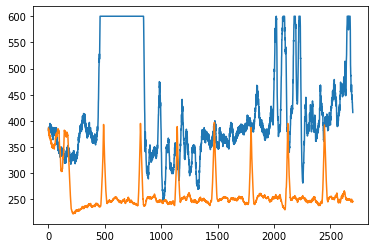

In [420]:
#!g1.1
train_dataloader1 = DataLoader(train_dataset, 64, True, drop_last=True)
test_dataloader1 = DataLoader(test_dataset, 1, True)

X, y = next(iter(train_dataloader1))

print(X.shape)
sns.lineplot(X[0, 0, :])
sns.lineplot(X[1, 0, :])

In [422]:
#!g1.1
import torch.nn as nn 
import torch.nn.functional as F

ls = [3, 10, 25]
ks = [5, 10, 20]

# Маска - оставляет каждую k-ю точку
class DownSampler(nn.Module):
#     b, c, n
    def __init__(self, insize, ks):
        super().__init__()
        self.insize = insize
        self.ks = ks
        self.masks = None
    
    def initialize_masks(self, x):
        self.masks = nn.Parameter(torch.tensor([[
            [1 if i % k == 0 else 0 for i in range(self.insize)] for k in self.ks
        ] for _ in range(x.shape[0])], device=device), requires_grad=False)
    
    def forward(self, x):
        if self.masks is None:
            self.initialize_masks(x)
        res = (self.masks * x).view(x.shape[0], 1, self.insize * len(self.ks))
        return res

class MultiScaleNN(nn.Module):
    def __init__(self, insize, ks, f, p, out_channels=32):
        super().__init__()
        self.insize = insize
        self.k_size = int(f * self.insize * len(ks))
        self.p_size = (self.insize * len(ks)) // p
        self.ks = ks
        self.out_size = (insize * len(ks) - k_size + 1  - p_size) // p_size + 1
        self.downsampler = DownSampler(insize, ks)
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=k_size, stride=1), # insize - (filter_size - 1)
            nn.MaxPool1d(kernel_size=p_size, stride=p_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear((self.out_size  * out_channels), 1000), 
            nn.ReLU()
        )
    def forward(self, x):
        x = self.downsampler(x)
        x = self.model(x)
        return x.unsqueeze(dim=1)

# Маска - усреднение 
class Smoother(nn.Module):
    def __init__(self, insize, ls=[3, 10, 25]):
        super().__init__()
        self.insize=insize
        self.ls = ls
        self.masks = None
        
    
    def initialize_masks(self, x):
        ones = [torch.ones((self.insize, l), device=device) for l in self.ls]
        masks = []
        for i, l in enumerate(self.ls):
            right_pad = self.insize - l + 1
            output = F.pad(ones[i], (0, right_pad), "constant", value=0)
            output = output.flatten()[:-self.insize].reshape(self.insize, self.insize)
            output *= torch.triu(torch.ones_like(output,  device=device))
            masks.append(output)
#             print(output.device)
        mask = torch.block_diag(*masks)
        mask = mask / (torch.sum(mask, 1).unsqueeze(-1))
        self.masks = nn.Parameter(mask.T, requires_grad=False)
        self.multiplier = nn.Parameter(torch.hstack([torch.eye(x.shape[2], device=device) for _ in range(len(self.ls))]), requires_grad=False)
#         print(self.masks.device, self.multiplier.device)
    
    def forward(self, x):
        if self.masks is None:
            self.initialize_masks(x)
        x = x @ self.multiplier
        return x @ self.masks
        
        
class MultiFrequencyNN(nn.Module):
    def __init__(self, insize, ls, f, p, out_channels=32):
        super().__init__()
        self.smoother = Smoother(insize, ls)
        self.k_size = int(f * insize)
        self.p_size = (insize) // p
        self.out_size = (insize * len(ls) - k_size * len(ls) + 1  - p_size * len(ls)) // (p_size * len(ls))  + 1
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=k_size * len(ls), padding=0, stride=1), 
            nn.MaxPool1d(kernel_size=p_size * len(ls), stride=p_size * len(ls), padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.out_size  * out_channels, 1000),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.smoother(x)
#         print(x.shape)
        x = self.model(x)
        return x.unsqueeze(dim=1)

class IdentityNN(nn.Module):
    def __init__(self, insize, f, p, out_channels=32):
        super().__init__()
        self.k_size = int(f * insize)
        self.p_size = (insize) // p
        self.out_size = (insize - k_size + 1  - p_size) // p_size  + 1
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=k_size, padding=0, stride=1), 
            nn.MaxPool1d(kernel_size=p_size, stride=p_size, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.out_size  * out_channels, 1000),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x.unsqueeze(dim=1)

class MCNN(nn.Module):
    def __init__(self, insize=2699, ls=[3, 10, 50], ks=[2, 3, 5], f=0.1, p=500, SERIES_SIZE=2699, out_channels=256):
        super().__init__()
        self.insize = insize
        self.SERIES_SIZE = SERIES_SIZE
        self.id = IdentityNN(insize, f, p, out_channels=32) #1000
        self.mf =  MultiFrequencyNN(insize, ls, f, p, out_channels=32) #1000
        self.ms = MultiScaleNN(insize, ks, f, p, out_channels=32) #1000
        self.size = 3000
        self.k_size = int(f * self.size)
        self.p_size = self.size // p
        self.full_conv_size = ((self.size - k_size + 1  - p_size) // p_size) + 1
        self.full_conv = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels=out_channels, kernel_size=k_size, stride=1, padding=0), # 300
            nn.MaxPool1d(kernel_size=p_size, stride=p_size, padding=0), # 150
            nn.ReLU(), 
            nn.Flatten(), 
            nn.Linear(self.full_conv_size * out_channels, 256),
            nn.Linear(256, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        orig = self.id(x)
        mf = self.mf(x)
        ms = self.ms(x)
        x = torch.cat([orig, mf, ms], dim=2)
        return self.full_conv(x)


# Берем сигнал -> разбиваем на подсигналы -> предсказываем каждый -> предсказываем исходный как наиболее частое предсказание   
    def majority_vote(self, x):
#         x = (1, )
#         print(f"x shape = {x.shape}")
        batch = x[:, :, 0:self.insize]
        with torch.no_grad():
            step = (x.shape[2] - self.insize) // 64
            for i in range(1, 64):
#                 print(i * self.insize, step)
                batch = torch.vstack((batch, x[:, :, step * i: self.insize + step * i]))
#             print(batch.shape)
#             print(batch.shape)
            votes = self.forward(batch)
            labels = torch.argmax(votes, dim=1)
#             print(f"labels shape = {labels.shape}")
            return torch.mode(labels)[0].item()


In [418]:
#!g1.1
device = "cuda"
def trainloop(model, dataloader, optimizer, loss_fn, loss_history, accuracy_history):
  correct = 0
  running_loss = 0
  for i, data in enumerate(tqdm(dataloader)):
    X, y = data
    X, y = X.to(device=device,  dtype=torch.float), y.to(device=device,  dtype=torch.long)
    optimizer.zero_grad()
    probas = model(X)
    loss = loss_fn(probas, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        labels = torch.argmax(probas, dim=1)
        correct += torch.sum(labels == y).item()
        running_loss += loss.item()
#     print(X.grad)
        if i % 50 == 0:
            print(f"Loss: {loss / 64}, acc: {torch.sum(labels == y).item() / 64}")
  print(f"Loss: {running_loss}, acc: {correct / len(dataloader.dataset)}")
  loss_history.append(running_loss)
  accuracy_history.append(correct/len(dataloader.dataset))

def testloop(model, dataloader, accuracy_history_val):
  correct = 0
  with torch.no_grad():
      for _, data in enumerate(tqdm(dataloader)):
        X, y = data
        X, y = X.to(device,  dtype=torch.float), y.to(device,  dtype=torch.long)
        labels = model.majority_vote(X)
        correct += (labels == y)
      print(f"Accuracy: {correct/(len(dataloader.dataset))}")
      accuracy_history_val.append(correct/(len(dataloader)))
    
def train_and_test(epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn):
    loss_h, acc_h = [], []
    acc_val = []
    for i in trange(epochs):
      print(f"Epoch {i+1}/{epochs}")
      trainloop(model, train_dataloader, optimizer, loss_fn, loss_h, acc_h)
      testloop(model, test_dataloader, acc_val)
      plt.plot(acc_val, label="Val accuracy")
#       print(len(acc_val))
      plt.plot(acc_h, label="Train accuracy")
      plt.legend()
      plt.show()

In [ ]:
#!g1.1
import torch.optim as optim
from tqdm.notebook import tqdm, trange
device = "cuda" if torch.cuda.is_available() else "cpu"
device

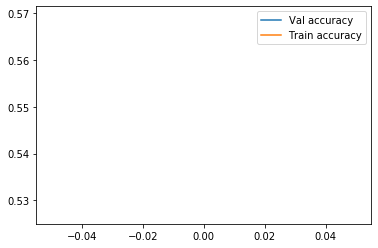

Epoch 1/5
Loss: 0.010924715548753738, acc: 0.515625
Loss: 0.011974791996181011, acc: 0.546875
Loss: 0.012707212008535862, acc: 0.5
Loss: 0.011486509814858437, acc: 0.578125
Loss: 0.010265807621181011, acc: 0.65625
Loss: 0.011242369189858437, acc: 0.59375
Loss: 0.012463072314858437, acc: 0.515625
Loss: 0.010998228564858437, acc: 0.609375
Loss: 0.011486510746181011, acc: 0.578125
Loss: 0.011730650439858437, acc: 0.5625
Loss: 0.011730650439858437, acc: 0.5625
Loss: 0.010265806689858437, acc: 0.65625

Loss: 427.55823254585266

Accuracy: tensor([0.5271], device='cuda:0')
Epoch 2/5
Loss: 0.00953338760882616, acc: 0.703125



In [ ]:
#!g1.1
import torch.optim as optim
model = MCNN(insize=2699)
model = model.to(device=device)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 1e-4)
train_and_test(5, model, train_dataloader1, test_dataloader1, optimizer, loss_fn) 